**Model Formulation**

The very first step is to define the model. Remember that we need a model of a control system in the following form:
\begin{eqnarray}
x_{k+1} = Ax_k + B u_k.
\end{eqnarray}
We must define the state vector and the model parameters. To begin, we must identify the differential equation that governs the motion of the system. For mechanical systems, Newton's laws usually allows us deriving such differential equation. The second low reads (sum of forces equals mass $\times$ acceleration):
\begin{eqnarray}
\sum \vec F = m\vec{a}.
\end{eqnarray}
For a rotating segment the analog in rotation is (sum of torque loads equals inertia $\times$ angular acceleration, noted $\vec{a}_R$):
\begin{eqnarray}
\sum \vec T = I\vec{a}_{R}.
\end{eqnarray}
We call $\theta$ the angle as a function of time. There is one degree of freedom so we will drop the vector notation and work with a scalar ordinary differential equation (ODE). Thus, the angular acceleration is the second derivative of $\theta$. We will consider two sources of torque loads (modelling choice, to be discussed !): a dissipative torque opposite and proportional to velocity with constant $G>0$, plus the actuator torque that is generated by the controller ($T$). Equation \ref{newton} becomes:
\begin{eqnarray}
I\ddot{\theta} = -G\dot{\theta} + T.
\end{eqnarray}
We will add a muscle model which transforms the command (representing the neural signal) into joint torque. In agreement with physiological studies (Li, 2007), we use a first order filter with time constant $\tau = 60$ms. The linear differential equation for the muscle model is then:
\begin{eqnarray}
\tau \dot{T} = u - T,
\end{eqnarray}
where $u$ represents the input to the system. Equations \ref{sys1} and \ref{sys2} capture the system dynamics. Since the system model involves the derivative of $T$ and the second derivative of $\theta$, we can define the following state vector: $x = [\theta, \dot{\theta}, T]^T$. We rewrite the two equations as follows:
\begin{eqnarray}
\left[
\begin{array}{c}
\dot{\theta}\\
\ddot{\theta}\\
\dot{T}
\end{array}\right]
&=&
\left[
\begin{array}{ccc}
0 &1& 0\\
0 & -G/I & 1/I \\
0 & 0 & -1/\tau
\end{array}\right]
\left[
\begin{array}{c}
\theta\\
\dot{\theta}\\
T
\end{array}\right]+
\left[
\begin{array}{c}
0\\
0\\
1/\tau
\end{array}\right]u\\
\nonumber&\Leftrightarrow&\\
\dot{x} &=& A_cx +B_cu,
\end{eqnarray}
where the subscript $c$ stands for continuous time dynamics.

This representation is an algebraic form for the system of ODEs. We are almost done. Remember we would like a discrete time system in order to include stochastic disturbances. This can be done in various ways. A popular technique is to use explicit Euler integration over one time step (note that an exact form is given with matrix exponentials). This is based on first order Taylor expansion over time ($\mathcal{I}$ is the identity matrix):
\begin{eqnarray}
x(t+\delta t) &=& x(t) +\delta t \dot{x} (t),\\
x(t+\delta t) &=& x(t) +\delta t (A_cx(t)+B_cu(t)),\\
x(t+\delta t) &=& (\mathcal{I} + \delta t A_c)x(t) +\delta t B_cu(t).
\end{eqnarray}
If we equate $t$ with index $k$ and consider that $\delta t$ is one time step, we can define $A := \mathcal{I} + \delta t A_c$, and $B:= \delta t B_c$, and we are done !

**Cost Function**

The framework of LQG allows minimising a cost of the form:
\begin{eqnarray}
J(x,u) = x_N^T Q_N x_N + \sum_{k=1}^{N-1} \left(x_k^T Q_k x_k + u_k^T R u_k\right)
\end{eqnarray}
We could either map all target to $0$, or if we want to do target jumps we can include a target vector consisting of desired (fixed) coordinates ($x^*$) and augment the state vector as follows: $z_k^T = [x_k^T, x_k^{*T}]$. Note that the state spaces matrices must be augmented to include the target state with dynamics $\dot{x}^* = 0$ for a static target.

Now observe that defining $e_n$ as the $n$-th row of the identity matrix of the same size of $x$, and $Q = w[e_n;-e_n][e_n^T, -e_n^T]$, we have:
\begin{eqnarray}
z_k^T Q z_k = w(x[n]_k-x[n]^*_k)^2,
\end{eqnarray}
where the notation "$.[n]$" designates the $n$-th entry of the corresponding vector. This technique can be used to define a cost function fo the general form:
\begin{eqnarray}
J(x) = w_1(\theta_k-\theta^*_k)^2 + w_2(\dot{\theta}_k-\dot{\theta}^*_k)^2 +w_3(T_k-T^*_k)^2.
\end{eqnarray}

In the example we use $Q_N = w(x_N-x_N^*)^2$, $Q_k = 0$, $k<N$ and $R$ a constant parameter.


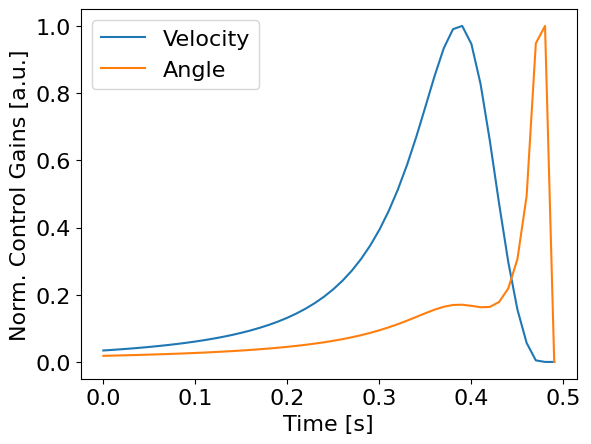

In [ ]:
# script_LQG
import matplotlib.pyplot as plt
import numpy as np
################################################################################
# LQG control for the modelling of a single joint elbow rotation
# Addition: target jump and dependency of the control response on the penalty
# on velocity (undershoot, hit VS stop, see Liu and Todorov, 2007)


# Simulation parameters and model matrices -------------------------------------
# Numerical parameters
G = 0.14      # viscous constant
I = 0.1       # inertia
tau = 0.066   # muscle time constant
delta = 0.01  # Time step

A0 = np.zeros(shape=(3,3))
A0[0,:] = [0,1,0]
A0[1,:] = [0, -G/I, 1/I]
A0[2,:] = [0, 0, -1/tau]

B0 = np.zeros(shape=(3,1))
B0[0] = 0
B0[1] = 0
B0[2] = 1/tau

ns = len(A0)     # dimension of the state vector
nc = len(B0[0])  # dimension of the control vector

# Discrete time
A0 = np.identity(ns)+delta*A0
B0 = delta*B0

# Augmentation of the system matrices to include the target
A = np.zeros(shape=(2*ns,2*ns))
A[0:3,0:3] = A0
A[3:6,3:6] = np.identity(ns)
B = np.zeros(shape=(2*ns,nc))
B[0:3]=B0

# Definition of the cost-function and time -------------------------------------
rtime = 0.5
nStep = int(np.round(rtime/delta))
Q = np.zeros(shape=(nStep+1,2*ns,2*ns))
R = np.zeros(shape=(nStep,nc,nc))

for i in range(nStep):
  R[i,:,:] = 10**-5*np.identity(nc)

w = np.zeros(shape=(1,ns))
w[0,:] = [1,1,0]             # Changing the cost of velocity can be done here

for i in range(ns):
  ei = 0*np.ndarray(shape=(2*ns,1))
  ei[i] = 1
  ei[i+ns] = -1
  Q[nStep,:,:] = Q[nStep,:,:] + w[0,i]*np.matmul(ei,np.transpose(ei))
  Q[nStep-1,:,:] = Q[nStep-1,:,:] + w[0,i]*np.matmul(ei,np.transpose(ei))

# Backward recurrence to calculate the optimal feedback gains ------------------
S=np.zeros(shape=(nStep+1,2*ns,2*ns))                 # Initialisation
S[nStep,:,:] = Q[nStep,:,:]
SigmaXi = 0.05*B@np.transpose(B)                      # Noise covariance matrix
sadd = 0                                              # Offset cost of noise
L = np.zeros(shape=(nStep,nc,2*ns))
gain1 = np.zeros(shape=(nStep,1))
gain2 = np.zeros(shape=(nStep,1))

for i in reversed(range(nStep)):
  # Fill in gain matrix
  p1 = np.matmul(np.transpose(B),S[i+1,:,:])
  den = np.linalg.inv(R[i,:,:]+np.matmul(p1,B))
  L[i,:,:] = den@np.transpose(B)@S[i+1,:,:]@A

  #Update recurrence matrices
  t1 = A-np.matmul(B,L[i,:,:])
  t2 = np.matmul(S[i+1,:,:],t1)
  t3 = np.matmul(np.transpose(A),t2)
  S[i,:,:] = Q[i,:,:]+t3

  # Update the offset cost
  sadd = sadd + np.trace(np.matmul(S[i+1,:,:],SigmaXi))

  #Gain functions to plot
  gain1[i,0]=L[i,0,0]
  gain2[i,0]=L[i,0,1]


#Plotting the control gains
plt.figure(1)
time = np.array(range(50))*delta
plt.plot(time,gain1/np.max(gain1))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.plot(time,gain2/np.max(np.abs(gain2)))
plt.xlabel('Time [s]',fontsize=16)
plt.ylabel('Norm. Control Gains [a.u.]',fontsize=16)
plt.legend({'Velocity','Angle'},fontsize=16)


To simulate the target jump, you can modify the following line:

`#target jump` <br>
`if i== (tpert):` <br>
`. . currentState[3] = currentState[3] + (jump)*np.pi/180`

The variable `tpert` is the time of the perturbation (between 1 and 50) and the variable `jump` is the amplitude of the target jump in degrees. To reproduce the restuls of Liu and Todorov (Journal of Neuroscience, 2017) you can modify the time of the perturbation and observe that perturbations that come later produce incomplete corrections.

<ipython-input-2-661df7a9716f>:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  control[0,i]=u


Text(0, 0.5, 'Control Vector')

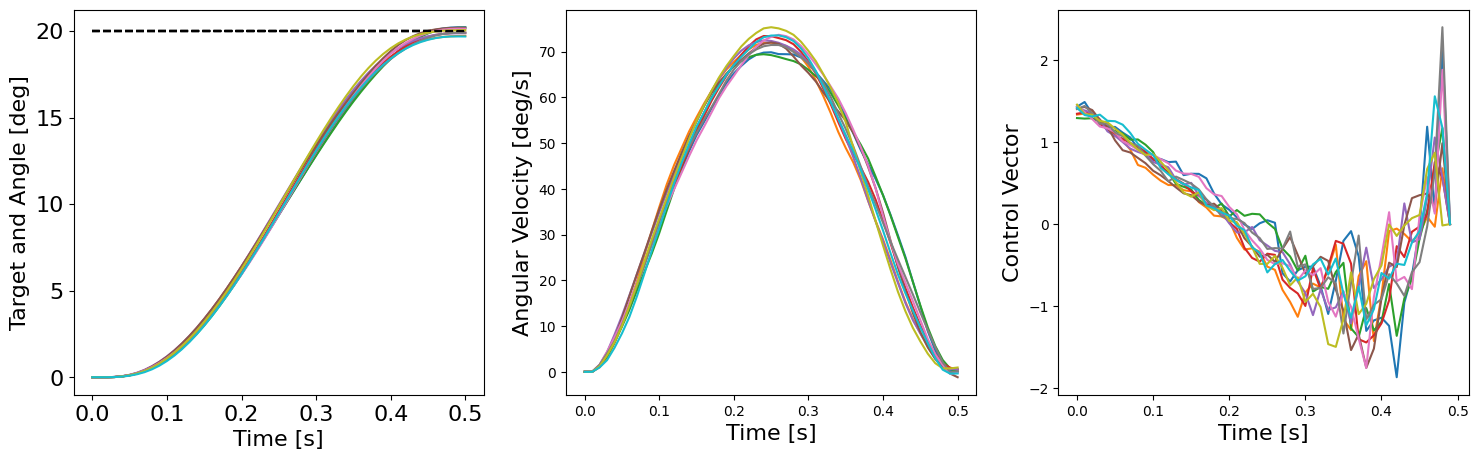

In [ ]:
# Forward recurrence -----------------------------------------------------------
# Kalman filter
H = np.identity(2*ns)
ny = len(H)
SigmaOmega = 0.1*np.max(SigmaXi)*np.identity(ny)
SigmaOmega[3,3] = 0.1*np.max(SigmaXi)
Sigma = 0.1*np.max(SigmaXi)*np.identity(ny)
K = np.zeros(shape=(nStep,2*ns,ny))

SigmaXi[3,3] = 0.01*SigmaXi[2,2] # Trick to allow target switches

for i in range(nStep):
  # Computation of gain value
  g1 = np.matmul(Sigma,np.transpose(H))
  g2 = np.matmul(A,g1)
  g3 = np.matmul(H,g1)+SigmaOmega
  K[i,:,:] = np.matmul(g2,np.linalg.inv(g3))

  # Update of Covariance Matrix
  h1 = A-np.matmul(K[i,:,:],H)
  h2 = np.matmul(Sigma,np.transpose(A))
  Sigma = SigmaXi + np.matmul(h1,h2)

SigmaXi[3,3] = 0


# System Dynamics---------------------------------------------------------------
xstate = np.zeros(shape=(nStep+1,2*ns))
xest = np.zeros(shape=(nStep+1,2*ns))
control = np.zeros(shape=(1,nStep))
xstate[0,3] = 20*np.pi/180
xest[0,3] = 20*np.pi/180
nSimu = 10

xmean = np.zeros(shape=(nStep+1,1))
xall = np.zeros(shape=(nStep+1,nSimu))

time1 = np.array(range(51))*delta
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
ax1.tick_params(labelsize=16)

for p in range(nSimu):
  # Variability in initial conditions:
  #xstate[0,:] = np.random.multivariate_normal(np.zeros(ny), SigmaOmega,tol=1e-8)
  xest[0,:] = xest[0,:] + np.random.multivariate_normal(np.zeros(ny), SigmaOmega,tol=1e-8)

  for i in range(nStep):
    currentState = np.transpose(xstate[i,:])

    #target jump
    if i==35:
      currentState[3] = currentState[3] + -0*np.pi/180

    currentEstimate = np.transpose(xest[i,:])

    #u = np.matmul(-L[i,:,:],currentState)
    u = np.matmul(-L[i,:,:],currentEstimate)

    xi = np.random.multivariate_normal(np.zeros(2*ns), SigmaXi ,tol=1e-8)
    omega = np.random.multivariate_normal(np.zeros(ny), SigmaOmega,tol=1e-8)
    y = np.matmul(H,currentState)+omega
    innovation = y-np.matmul(H,currentEstimate)

    nextState = np.matmul(A,currentState) + np.matmul(B,u) + np.transpose(xi)
    nextEstimate = np.matmul(A,currentEstimate) + np.matmul(B,u) + np.matmul(K[i,:,:],innovation)
    xstate[i+1,:] = np.transpose(nextState)
    xest[i+1,:] = np.transpose(nextEstimate)
    control[0,i]=u



  #plt.figure(2)
  ax1.plot(time1,xstate[:,3]*180/np.pi,'k--')
  ax2.plot(time1,xstate[:,1]*180/np.pi)
  ax1.plot(time1,xstate[:,0]*180/np.pi)

  xmean[:,0] += xstate[:,0]/nSimu
  xall[:,p] = xstate[:,0]

  #plt.figure(3)
  ax3.plot(time,np.transpose(control))

ax1.set_xlabel('Time [s]', fontsize=16)
ax1.set_ylabel('Target and Angle [deg]', fontsize=16)


ax2.set_xlabel('Time [s]', fontsize=16)
ax2.set_ylabel('Angular Velocity [deg/s]', fontsize=16)

ax3.set_xlabel('Time [s]', fontsize=16)
ax3.set_ylabel('Control Vector', fontsize=16)



#plt.figure(2)
#plt.figure(3)
#plt.xlabel('Time [s]')
#plt.ylabel('Command Value [Nm]')




The plot below showns the target state and the estimated target state by the Kalman filter. To reproduce the results of Izawa and Shadmehr (Journal of Neuroscience, 2018) you can simulate different levels of noise affecting the sensory signal. This can be done by modifying the line above:
`SigmaOmega = scaling*np.max(SigmaXi)*np.identity(ny)`,

where `scaling` can take different values (try for instance 0.5, 0.1, and 0.05). You will observe that the correction is more vigorous for lower values of the `scaling` parameter, and the estimate of the target state goes faster to the novel value after the target jump.


Text(0, 0.5, 'Terget and Estimate')

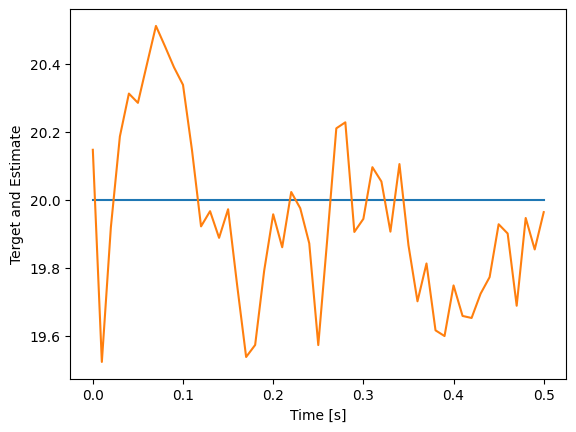

In [ ]:
plt.plot(time1,xstate[:,3]*180/np.pi)
plt.plot(time1,xest[:,3]*180/np.pi)
plt.xlabel('Time [s]')
plt.ylabel('Terget and Estimate')
